**Goal**: To build an AI agent that analyzes a novel and provides insights through data visualizations—such as word count by chapter, word frequency heatmaps, and sentiment arcs.

* Framework: The agentic workflow is built using the LangGraph framework.

* LLM (Reasoning Engine): Mistral AI's model is used as the core reasoning component (the "brain") of the system.

**Install packages**

In [ ]:
!pip install langgraph langchain mistralai gradio --quiet
!pip install -U langchain-community langgraph langchain-anthropic tavily-python langgraph-checkpoint-sqlite
!pip install -qU "langchain[mistralai]"
!pip install ebooklib beautifulsoup4

**Import packages**

In [3]:
import requests
import json
import os
from collections import Counter
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.chat_models import init_chat_model
import gradio as gr
from langchain.schema import HumanMessage
from langchain.tools import tool
import ebooklib
from ebooklib import epub, ITEM_DOCUMENT
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import numpy as np
import tempfile
from typing import List, Dict
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords


**Setup the API key**

In [23]:
os.environ["MISTRAL_API_KEY"] = "MISTRAL_API_KEY"

**Define the tool that extracts chapters, get the word count chapterwise and plots the barplot.**

In [5]:
def extract_clean_chapters(epub_path):
    skip_titles = ['about the author', 'acknowledgment', 'acknowledgements',
                   'copyright', 'table of contents', 'dedication', 'preface', 'foreword']
    book = epub.read_epub(epub_path)
    chapters = {}

    chapter_index = 1
    for item in book.get_items():
        if item.get_type() == ebooklib.ITEM_DOCUMENT:
            soup = BeautifulSoup(item.get_content(), 'html.parser')
            text = soup.get_text().strip()
            title_tag = soup.title.string if soup.title else None
            title = title_tag.strip() if title_tag else f"Chapter {chapter_index}"

            title_lower = title.lower()
            if any(skip in title_lower for skip in skip_titles):
                continue
            if len(text.split()) < 300:
                continue

            chapters[title] = text
            chapter_index += 1

    return chapters

def plot_word_count(chapter_word_counts):
    titles = list(chapter_word_counts.keys())
    word_counts = list(chapter_word_counts.values())

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(titles)), word_counts, color='skyblue')
    ax.set_xticks(range(len(titles)))
    ax.set_xticklabels([f"{i+1}" for i in range(len(titles))], rotation=90)
    ax.set_xlabel("Chapters")
    ax.set_ylabel("Word Count")
    ax.set_title("Word Count per Chapter")
    plt.tight_layout()

    return fig  # Return the figure directly

@tool
def get_chapter_wordcount_plot(book_path: str) -> str:
    """
    Extracts chapter-wise word counts from an EPUB book and plots a bar chart.

    Args:
        book_path: Path to the .epub file.

    Returns:
        A dictionary with total chapter count, average word count, and plot image path.
    """
    chapters = extract_clean_chapters(book_path)
    chapter_word_counts = {title: len(text.split()) for title, text in chapters.items()}

    avg_words = sum(chapter_word_counts.values()) / len(chapter_word_counts) if chapter_word_counts else 0
    fig = plot_word_count(chapter_word_counts)

    image_path = "/tmp/wordcount_plot.png"
    fig.savefig(image_path)
    plt.close(fig)  # free memory
    return image_path


**Create a tool that splits the novel into chunks, analyzes every 1000 words and plots sentiment arc.**

In [ ]:
# Load sentiment model + tokenizer with correct label mapping
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model.config.id2label = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def extract_epub_text(epub_path: str) -> str:
    book = epub.read_epub(epub_path)
    text = []
    for item in book.get_items():
        if item.get_type() == ITEM_DOCUMENT:
            soup = BeautifulSoup(item.get_content(), "html.parser")
            text.append(soup.get_text())
    return ' '.join(' '.join(text).split())

def extract_text(file_path: str) -> str:
    if file_path.endswith(".epub"):
        return extract_epub_text(file_path)
    else:
        with open(file_path, "r", encoding="utf-8") as f:
            return ' '.join(f.read().split())

def chunk_text(text: str, chunk_size: int = 1000) -> List[str]:
    words = text.split()
    return [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]

def analyze_chunks(chunks: List[str]) -> List[float]:
    sentiment_scores = []
    for i, chunk in enumerate(chunks):  # analyze all chunks
        result = sentiment_pipeline(chunk[:512])[0]
        # print(f"Chunk {i}: {result}")  # useful for debugging
        label = result['label'].lower()
        confidence = result['score']
        if label == "positive":
            sentiment_scores.append(confidence)
        elif label == "negative":
            sentiment_scores.append(-confidence)
        else:  # neutral
            sentiment_scores.append(0.0)
    return sentiment_scores

def smooth(scores: List[float], window: int = 3) -> List[float]:
    return np.convolve(scores, np.ones(window)/window, mode='same')

def plot_sentiment_arc(scores: List[float], title="Sentiment Arc"):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(scores, color='teal', linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Book Position (Chunks)")
    ax.set_ylabel("Sentiment Score")
    ax.grid(True)
    plt.tight_layout()
    return fig  # return the matplotlib figure

@tool
def get_sentiment_arc(book_path: str) -> str:
    """
    Generates a sentiment arc from a .txt or .epub book file.

    Args:
        book_path: Path to the .txt or .epub book file.

    Returns:
        A dictionary with chunk count, average sentiment score, and plot path.
    """
    text = extract_text(book_path)
    chunks = chunk_text(text)
    raw_scores = analyze_chunks(chunks)
    smoothed_scores = smooth(raw_scores)

    fig = plot_sentiment_arc(smoothed_scores)

    image_path = "/tmp/sentiment_arc.png"
    fig.savefig(image_path)
    plt.close(fig)  # free memory
    return image_path

**Define a tool that fetches the most frequent words and plots the heatmap.**

In [ ]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def extract_epub_chapters(epub_path: str) -> List[str]:
    book = epub.read_epub(epub_path)
    chapters = []
    for item in book.get_items():
        if item.get_type() == ITEM_DOCUMENT:
            soup = BeautifulSoup(item.get_content(), "html.parser")
            text = soup.get_text()
            cleaned = re.sub(r'\s+', ' ', text.strip())
            if len(cleaned.split()) > 50:
                chapters.append(cleaned)
    return chapters

def extract_chapters(file_path: str) -> List[str]:
    if file_path.endswith(".epub"):
        return extract_epub_chapters(file_path)
    else:
        with open(file_path, "r", encoding="utf-8") as f:
            full_text = f.read()
        split_text = re.split(r'\n\s*(Chapter|CHAPTER|chapter)\s+\d+', full_text)
        return [t.strip() for t in split_text if len(t.split()) > 50]

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join([w for w in text.split() if w not in STOPWORDS])

def extract_theme_words(chapters: List[str], top_n: int = 10) -> List[str]:
    cleaned = [clean_text(c) for c in chapters]
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(cleaned)
    summed_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
    word_scores = list(zip(vectorizer.get_feature_names_out(), summed_scores))
    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return [w for w, _ in top_words]

def compute_normalized_frequencies(chapters: List[str], theme_words: List[str]) -> List[Dict[str, float]]:
    freq_matrix = []
    for chap in chapters:
        tokens = clean_text(chap).split()
        total = len(tokens)
        freqs = {w: tokens.count(w) / total for w in theme_words}
        freq_matrix.append(freqs)
    return freq_matrix

def plot_heatmap(freq_matrix: List[Dict[str, float]], theme_words: List[str]) -> str:
    data = np.array([[chapter[word] for word in theme_words] for chapter in freq_matrix])
    fig, ax = plt.subplots(figsize=(15, 12), dpi=100)
    sns.heatmap(data, annot=True, cmap='viridis',
                xticklabels=theme_words,
                yticklabels=[f"C{i+1}" for i in range(len(freq_matrix))],
                ax=ax)

    ax.set_xlabel("Theme Words")
    ax.set_ylabel("Chapters")
    ax.set_title("Word Frequency Heatmap")
    plt.tight_layout()

    return fig  # return the matplotlib figure

@tool
def get_word_frequency_heatmap(book_path: str, top_n_words: int = 10) -> str:
    """
    Generates a word frequency heatmap from a .txt or .epub book.

    Args:
        book_path: Path to the .txt or .epub book file.
        top_n_words: Number of top theme words to extract via TF-IDF.

    Returns:
        A dictionary with chapter count, theme words, and heatmap image path.
    """
    chapters = extract_chapters(book_path)
    theme_words = extract_theme_words(chapters, top_n=top_n_words)
    freq_matrix = compute_normalized_frequencies(chapters, theme_words)
    fig = plot_heatmap(freq_matrix, theme_words)

    image_path = "/tmp/word_freq_heatmap.png"
    fig.savefig(image_path)
    plt.close(fig)  # free memory
    return image_path

**Define the state of the agent**

In [8]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

**Build the agent nodes and edges, create a workflow for the agent**

In [9]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_mistral_ai)
        graph.add_node("action", self.take_action)
        graph.add_node("final", self.final_answer)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "final")  # 🆕
        graph.add_edge("final", END)        # 🆕
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_mistral_ai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        return {'messages': results}

    def final_answer(self, state: AgentState):
        """Return the final tool output cleanly."""
        return {"messages": [AIMessage(content=state['messages'][-1].content.strip())]}

**Define the system prompt, model for reasoning**

In [10]:
prompt = """You are a reading Assistant. Your task is to help users analyze the novel, books, text.

Use the available tools to get overall summary of the book, novel. You can make multiple lookups if necessary, either together or in sequence.

Your goal is to ensure help the user.

"""

model = init_chat_model("mistral-large-latest", model_provider="mistralai")
abot = Agent(model, [get_chapter_wordcount_plot, get_word_frequency_heatmap, get_sentiment_arc], system=prompt)

**Testing with sample novel and prompt**

In [19]:
messages = [HumanMessage(content="""/content/The_Missing_Half_-_Ashley_Flowers.epub  Give me sentiment arc.""")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'get_sentiment_arc', 'args': {'book_path': '/content/The_Missing_Half_-_Ashley_Flowers.epub'}, 'id': 'YABbFvBt9', 'type': 'tool_call'}


**Printing every message of the agent**

In [20]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

/content/The_Missing_Half_-_Ashley_Flowers.epub  Give me sentiment arc.
================================== Ai Message ==================================
Tool Calls:
  get_sentiment_arc (YABbFvBt9)
 Call ID: YABbFvBt9
  Args:
    book_path: /content/The_Missing_Half_-_Ashley_Flowers.epub
================================= Tool Message =================================
Name: get_sentiment_arc

/tmp/sentiment_arc.png
================================== Ai Message ==================================

/tmp/sentiment_arc.png


In [21]:
result['messages'][-1].content

'/tmp/sentiment_arc.png'

**Outputs: Generated plots by the agents are shown below**

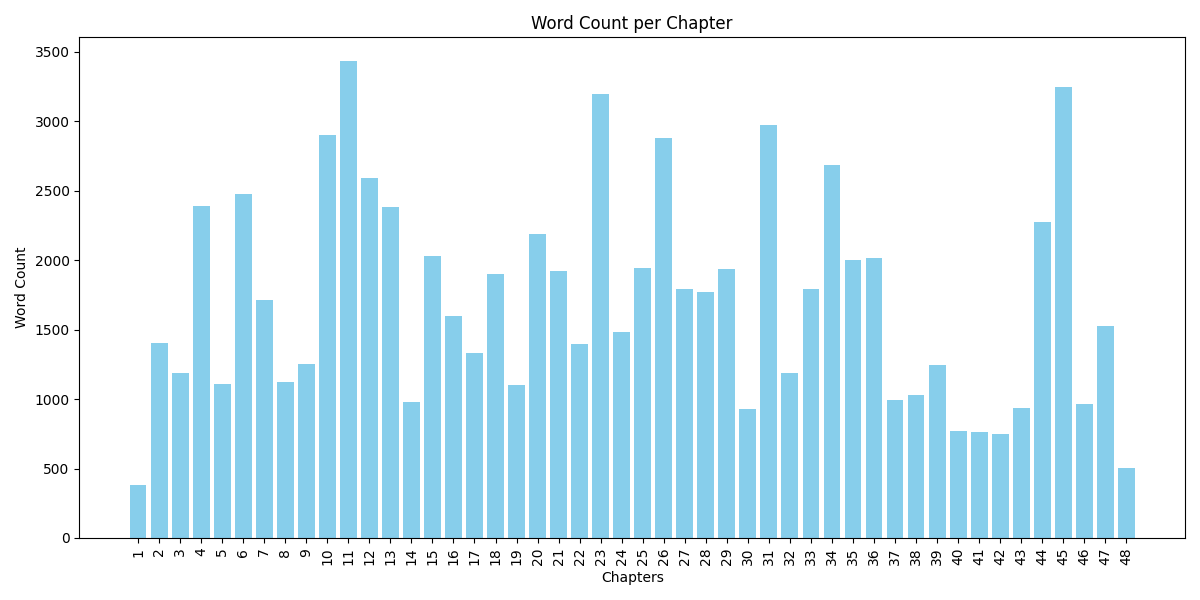

In [14]:
from IPython.display import Image

# Display the image
Image('/tmp/wordcount_plot.png')

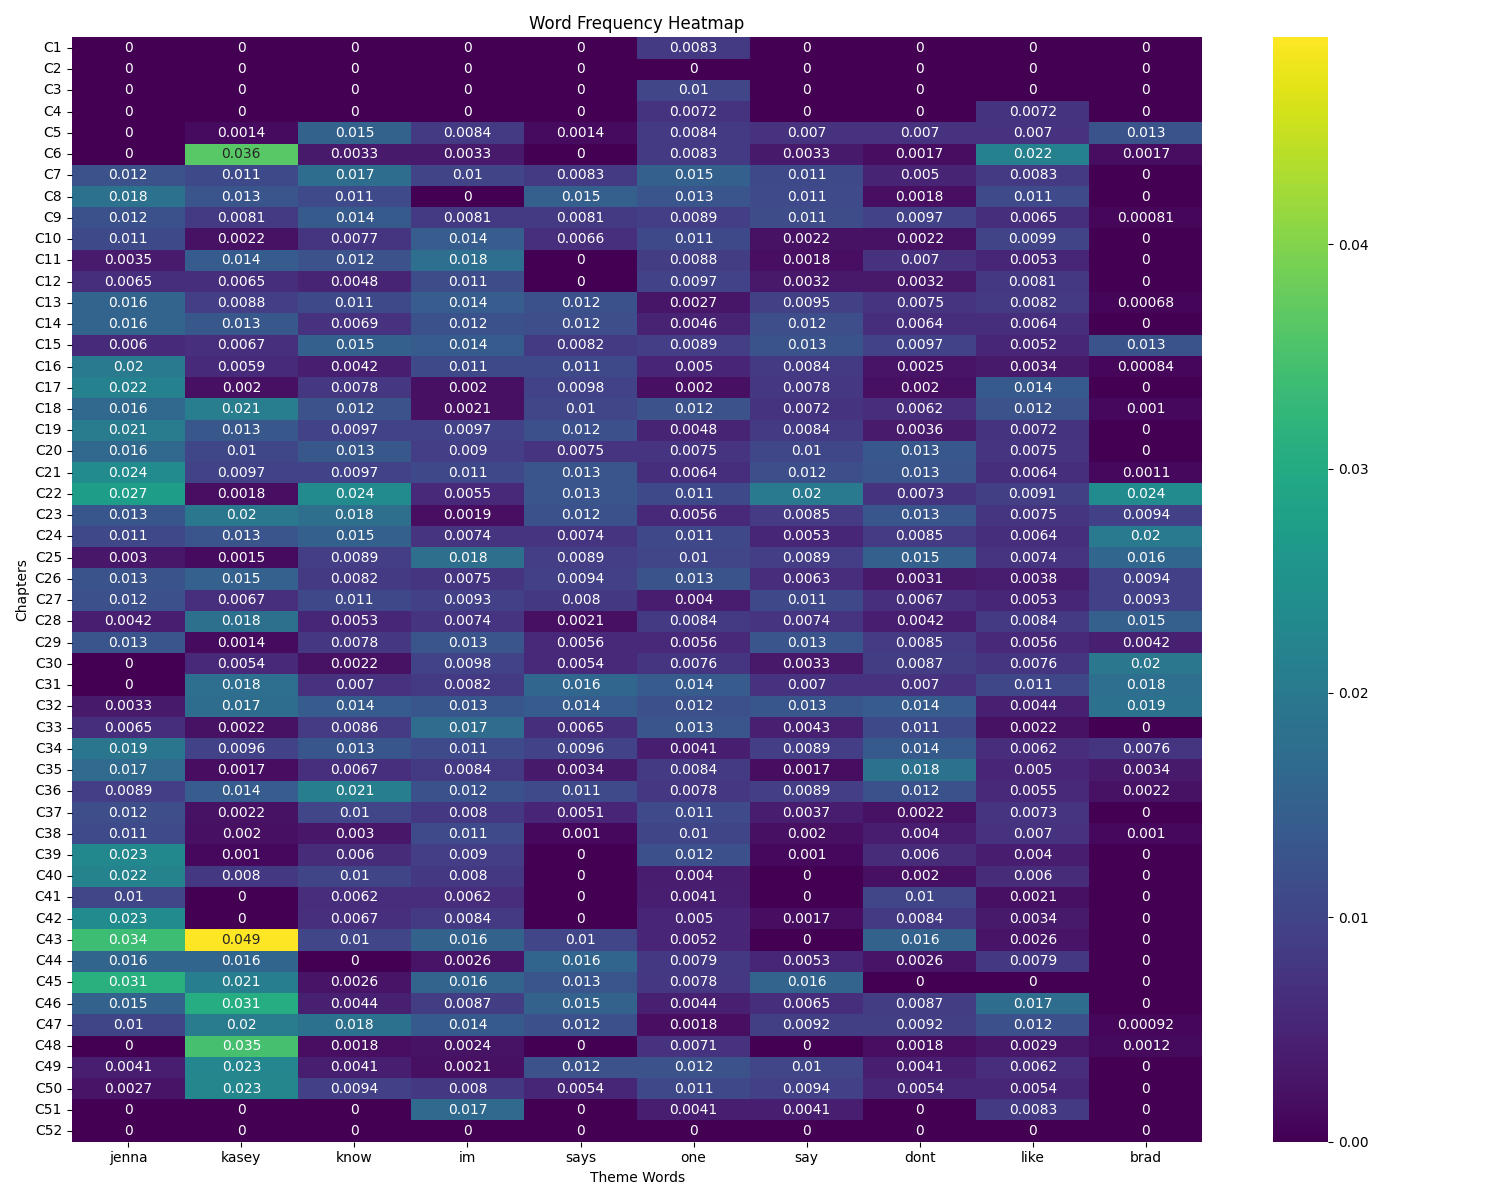

In [18]:
from IPython.display import Image

# Display the image
Image('/tmp/word_freq_heatmap.png')

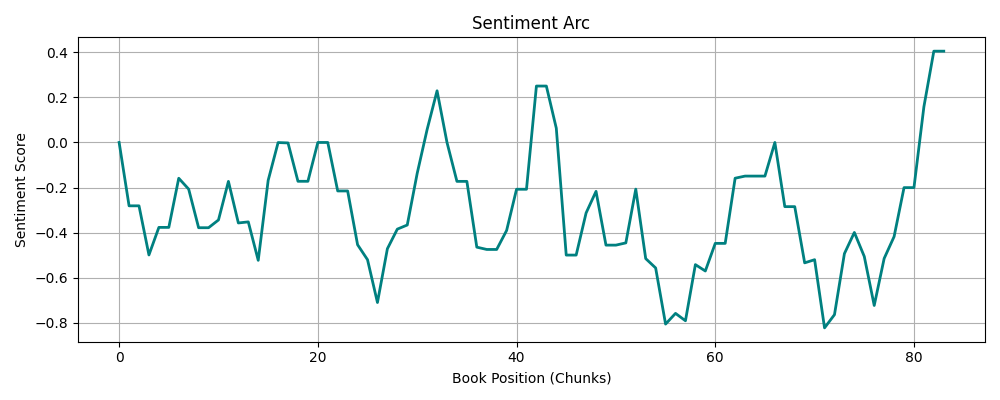

In [22]:
from IPython.display import Image

# Display the image
Image('/tmp/sentiment_arc.png')

**Conclusion:**

*   Agent was able to analyze the novel and successfully generate various plots based on the prompt


